This is the banchmarking of the network architecture 

In [1]:
from MEDfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MEDfl Imports 
## Network Manager Imports 
from MEDfl.NetManager.node import Node
from MEDfl.NetManager.network import Network
from MEDfl.NetManager.dataset import DataSet
from MEDfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from MEDfl.LearningManager.dynamicModal import DynamicModel
from MEDfl.LearningManager.model import Model
from MEDfl.LearningManager.strategy import Strategy
from MEDfl.LearningManager.server import *
from MEDfl.LearningManager.flpipeline import *
from MEDfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from MEDfl.LearningManager.utils import *


2024-02-21 15:10:01.818369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# DB Creation 
!python3 ../../../scripts/create_db.py

# clearn DB 
# empty_db()

In [4]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network")
Net_1.create_network()

Net_1.name

/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/pandas/io/sql.py:1761: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  return insp.has_table(name, schema or self.meta.schema)


'manual_network'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/notebooks/data/masterDataSet/Mimic_train.csv


1

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_1", description = "The first fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

,FLsetupId,name,description,creation_date,NetId,column_name
0,1,Flsetup_1,The first fl setup,2024-02-21 15:10:17,1,None


# Configuration_1: A Manual network with 5 Nodes 
This network contains 5 nodes (3 Train nodes and 2 test nodes)

In [7]:
# Create 5 nodes 
hospital_1,hospital_2,hospital_3, hospital_4 , hospital_5 = Node(name = "hospital_1", train = 1),Node(name = "hospital_2", train = 1),Node(name = "hospital_3", train = 1),Node(name = "hospital_4", train = 0),Node(name = "hospital_5", train = 0)

In [8]:
# Assign the 3 nodes to the man_network 
Net_1.add_node(hospital_1)
Net_1.add_node(hospital_2)
Net_1.add_node(hospital_3) 
Net_1.add_node(hospital_4)
Net_1.add_node(hospital_5) 

In [9]:
# List all created nodes on the db 
Node.list_allnodes()

,NodeId,NodeName,train,NetId
0,1,hospital_1,1,1
1,2,hospital_2,1,1
2,3,hospital_3,1,1
3,4,hospital_4,0,1
4,5,hospital_5,0,1


In [10]:
# Define the path of the files 
# Train Data 
Ds_1 = global_params['base_url']+ '/notebooks/data/nodesData/part_1.csv'
Ds_2 = global_params['base_url']+ '/notebooks/data/nodesData/part_2.csv'
Ds_3 = global_params['base_url']+ '/notebooks/data/nodesData/part_3.csv'

# pload the DataSets 
hospital_1.upload_dataset( dataset_name = "hospital_1_dataset" , path_to_csv=Ds_1  )
hospital_2.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=Ds_2)
hospital_3.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=Ds_3 )

# Test Data 
test_1 = global_params['base_url']+ '/notebooks/data/nodesData/test_1.csv'
test_2 = global_params['base_url']+ '/notebooks/data/nodesData/test_2.csv'

hospital_4.upload_dataset( dataset_name = "hospital_2_dataset" , path_to_csv=test_1)
hospital_5.upload_dataset( dataset_name = "hospital_3_dataset" , path_to_csv=test_2 )




In [11]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [12]:
fl_dataset.size

17

In [13]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.20619234,  0.08450875,  0.16178955,  0.18101399, -0.05696352,
         -0.05274155,  0.00760607, -0.15300614,  0.04326935,  0.08542655,
          0.13926396,  0.16641127, -0.17382003,  0.23927449,  0.03769074,
         -0.05113392, -0.16764468]], dtype=float32),
 array([0.12306646], dtype=float32)]

In [14]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [15]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = False ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [16]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the first fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [17]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-02-21 15:10:25,332 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
02/21/2024 15:10:25:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-21 15:10:27,523	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-21 15:10:29,987 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 39449923584.0, 'node:__internal_head__': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 24.0}
02/21/2024 15:10:29:INFO:Flower VCE: Ray initialized with resources: {'memory': 39449923584.0, 'node:__internal_head__': 1.0, 'object_store_memory': 78643200.0, 'node:10.44.86.57': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'CPU': 24.0}
INFO flwr 2024-02-21 15:10:29,988 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
02/21/2024 15:10:29:INFO:Opt

Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


(DefaultActor pid=404996) /home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/MEDfl/LearningManager/utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=404996)   global_yaml_path = pkg_resources.resource_filename(__name__, "../../global_params.yaml")
(DefaultActor pid=404996) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/opacus/privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=404996)   warnings.warn(
(DefaultActor pid=404996) /home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/flwr/simulation/ray_transport/ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.

(DefaultActor pid=404995) [Client 1] fit, config: {}
Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:38,011 | server.py:187 | evaluate_round 1 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2024-02-21 15:10:38,012 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
02/21/2024 15:10:38:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-02-21 15:10:38,012 | server.py:222 | fit_round 2: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:fit_round 2: strategy sampled 3 clients (out of 3)


(DefaultActor pid=404995) epsilon of client 1 : eps = 0
(DefaultActor pid=404995) [Client 2] evaluate, config: {}


DEBUG flwr 2024-02-21 15:10:38,289 | server.py:236 | fit_round 2 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:fit_round 2 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:38,292 | server.py:125 | fit progress: (2, 8.264462557705967, {'accuracy': 0.09090909090909091}, 8.280993513064459)
02/21/2024 15:10:38:INFO:fit progress: (2, 8.264462557705967, {'accuracy': 0.09090909090909091}, 8.280993513064459)
DEBUG flwr 2024-02-21 15:10:38,292 | server.py:173 | evaluate_round 2: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:evaluate_round 2: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:38,319 | server.py:187 | evaluate_round 2 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:38,319 | server.py:222 | fit_round 3: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:fit_round 3: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:38,573 | server.py:236 | fit_round 3 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:fit_round 3 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:38,576 | server.py:125 | fit progress: (3, 8.264462557705967, {'accuracy': 0.09090909090909091}, 8.565492671099491)
02/21/2024 15:10:38:INFO:fit progress: (3, 8.264462557705967, {'accuracy': 0.09090909090909091}, 8.565492671099491)
DEBUG flwr 2024-02-21 15:10:38,577 | server.py:173 | evaluate_round 3: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:evaluate_round 3: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:38,602 | server.py:187 | evaluate_round 3 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:38,603 | server.py:222 | fit_round 4: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:fit_round 4: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:38,873 | server.py:236 | fit_round 4 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:fit_round 4 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:38,876 | server.py:125 | fit progress: (4, 8.264462557705967, {'accuracy': 0.09090909090909091}, 8.865346135105938)
02/21/2024 15:10:38:INFO:fit progress: (4, 8.264462557705967, {'accuracy': 0.09090909090909091}, 8.865346135105938)
DEBUG flwr 2024-02-21 15:10:38,877 | server.py:173 | evaluate_round 4: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:evaluate_round 4: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:38,898 | server.py:187 | evaluate_round 4 received 3 results and 0 failures
02/21/2024 15:10:38:DEBUG:evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:38,899 | server.py:222 | fit_round 5: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:38:DEBUG:fit_round 5: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:39,164 | server.py:236 | fit_round 5 received 3 results and 0 failures
02/21/2024 15:10:39:DEBUG:fit_round 5 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:39,168 | server.py:125 | fit progress: (5, 8.264462557705967, {'accuracy': 0.09090909090909091}, 9.157629418070428)
02/21/2024 15:10:39:INFO:fit progress: (5, 8.264462557705967, {'accuracy': 0.09090909090909091}, 9.157629418070428)
DEBUG flwr 2024-02-21 15:10:39,170 | server.py:173 | evaluate_round 5: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:39:DEBUG:evaluate_round 5: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:39,194 | server.py:187 | evaluate_round 5 received 3 results and 0 failures
02/21/2024 15:10:39:DEBUG:evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:39,195 | server.py:222 | fit_round 6: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:39:DEBUG:fit_round 6: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:39,463 | server.py:236 | fit_round 6 received 3 results and 0 failures
02/21/2024 15:10:39:DEBUG:fit_round 6 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:39,467 | server.py:125 | fit progress: (6, 8.264462557705967, {'accuracy': 0.09090909090909091}, 9.456328990054317)
02/21/2024 15:10:39:INFO:fit progress: (6, 8.264462557705967, {'accuracy': 0.09090909090909091}, 9.456328990054317)
DEBUG flwr 2024-02-21 15:10:39,468 | server.py:173 | evaluate_round 6: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:39:DEBUG:evaluate_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:39,494 | server.py:187 | evaluate_round 6 received 3 results and 0 failures
02/21/2024 15:10:39:DEBUG:evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:39,495 | server.py:222 | fit_round 7: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:39:DEBUG:fit_round 7: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:39,772 | server.py:236 | fit_round 7 received 3 results and 0 failures
02/21/2024 15:10:39:DEBUG:fit_round 7 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:39,776 | server.py:125 | fit progress: (7, 8.264462557705967, {'accuracy': 0.09090909090909091}, 9.76520581310615)
02/21/2024 15:10:39:INFO:fit progress: (7, 8.264462557705967, {'accuracy': 0.09090909090909091}, 9.76520581310615)
DEBUG flwr 2024-02-21 15:10:39,777 | server.py:173 | evaluate_round 7: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:39:DEBUG:evaluate_round 7: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:39,802 | server.py:187 | evaluate_round 7 received 3 results and 0 failures
02/21/2024 15:10:39:DEBUG:evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:39,803 | server.py:222 | fit_round 8: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:39:DEBUG:fit_round 8: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:40,083 | server.py:236 | fit_round 8 received 3 results and 0 failures
02/21/2024 15:10:40:DEBUG:fit_round 8 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:40,087 | server.py:125 | fit progress: (8, 8.264462557705967, {'accuracy': 0.09090909090909091}, 10.075702299014665)
02/21/2024 15:10:40:INFO:fit progress: (8, 8.264462557705967, {'accuracy': 0.09090909090909091}, 10.075702299014665)
DEBUG flwr 2024-02-21 15:10:40,087 | server.py:173 | evaluate_round 8: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:40:DEBUG:evaluate_round 8: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:40,114 | server.py:187 | evaluate_round 8 received 3 results and 0 failures
02/21/2024 15:10:40:DEBUG:evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:40,115 | server.py:222 | fit_round 9: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:40:DEBUG:fit_round 9: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:40,391 | server.py:236 | fit_round 9 received 3 results and 0 failures
02/21/2024 15:10:40:DEBUG:fit_round 9 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:40,395 | server.py:125 | fit progress: (9, 8.264462557705967, {'accuracy': 0.09090909090909091}, 10.38466027204413)
02/21/2024 15:10:40:INFO:fit progress: (9, 8.264462557705967, {'accuracy': 0.09090909090909091}, 10.38466027204413)
DEBUG flwr 2024-02-21 15:10:40,397 | server.py:173 | evaluate_round 9: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:40:DEBUG:evaluate_round 9: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:40,422 | server.py:187 | evaluate_round 9 received 3 results and 0 failures
02/21/2024 15:10:40:DEBUG:evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2024-02-21 15:10:40,423 | server.py:222 | fit_round 10: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:40:DEBUG:fit_round 10: strategy sampled 3 clients (out of 3)


Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


DEBUG flwr 2024-02-21 15:10:40,696 | server.py:236 | fit_round 10 received 3 results and 0 failures
02/21/2024 15:10:40:DEBUG:fit_round 10 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:40,700 | server.py:125 | fit progress: (10, 8.264462557705967, {'accuracy': 0.09090909090909091}, 10.68874858203344)
02/21/2024 15:10:40:INFO:fit progress: (10, 8.264462557705967, {'accuracy': 0.09090909090909091}, 10.68874858203344)
DEBUG flwr 2024-02-21 15:10:40,700 | server.py:173 | evaluate_round 10: strategy sampled 3 clients (out of 3)
02/21/2024 15:10:40:DEBUG:evaluate_round 10: strategy sampled 3 clients (out of 3)
DEBUG flwr 2024-02-21 15:10:40,726 | server.py:187 | evaluate_round 10 received 3 results and 0 failures
02/21/2024 15:10:40:DEBUG:evaluate_round 10 received 3 results and 0 failures
INFO flwr 2024-02-21 15:10:40,727 | server.py:153 | FL finished in 10.715697793057188
02/21/2024 15:10:40:INFO:FL finished in 10.715697793057188
INFO flwr 2024-02-21 15:10:40,728 | app.py:22

Server-side evaluation loss 8.264462557705967 / accuracy 0.09090909090909091


(DefaultActor pid=404995) epsilon of client 0 : eps = 0
(DefaultActor pid=404995) [Client 0] evaluate, config: {}


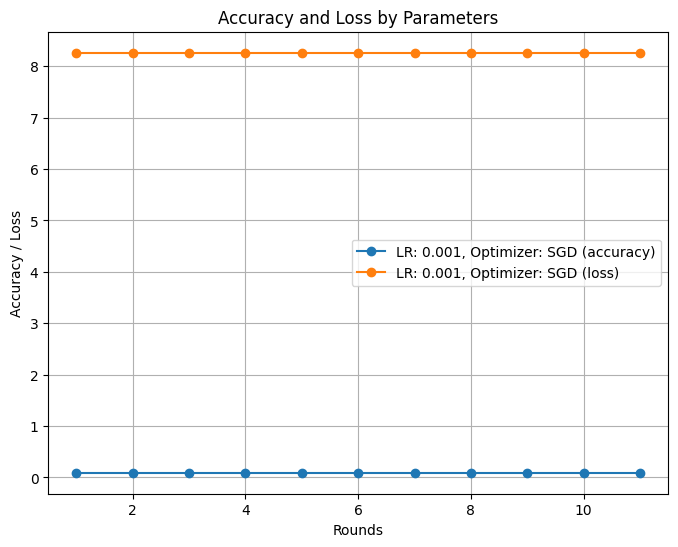

In [18]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [19]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 6, 'FP': 21, 'FN': 0, 'TN': 0}, 'Accuracy': 0.222, 'Sensitivity/Recall': 1.0, 'Specificity': 0.0, 'PPV/Precision': 0.222, 'NPV': 0.0, 'F1-score': 0.364, 'False positive rate': 1.0, 'True positive rate': 1.0}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 5, 'FP': 22, 'FN': 0, 'TN': 0}, 'Accuracy': 0.185, 'Sensitivity/Recall': 1.0, 'Specificity': 0.0, 'PPV/Precision': 0.185, 'NPV': 0.0, 'F1-score': 0.312, 'False positive rate': 1.0, 'True positive rate': 1.0}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 6, 'FP': 21, 'FN': 0, 'TN': 0}, 'Accuracy': 0.222, 'Sensitivity/Recall': 1.0, 'Specificity': 0.0, 'PPV/Precision': 0.222, 'NPV': 0.0, 'F1-score': 0.364, 'False positive rate': 1.0, 'True positive rate': 1.0}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion matrix': {'TP': 287, 'FP': 1503, 'FN': 0, '

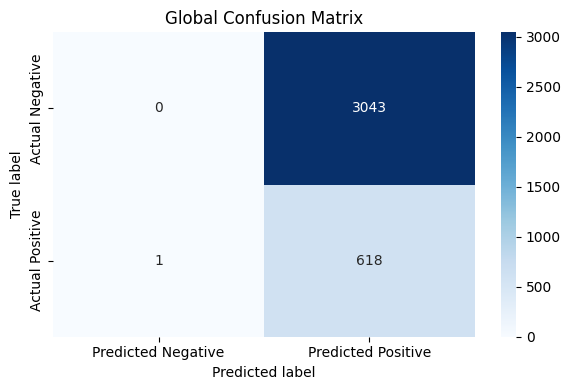

In [20]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the first fl_pipeline")

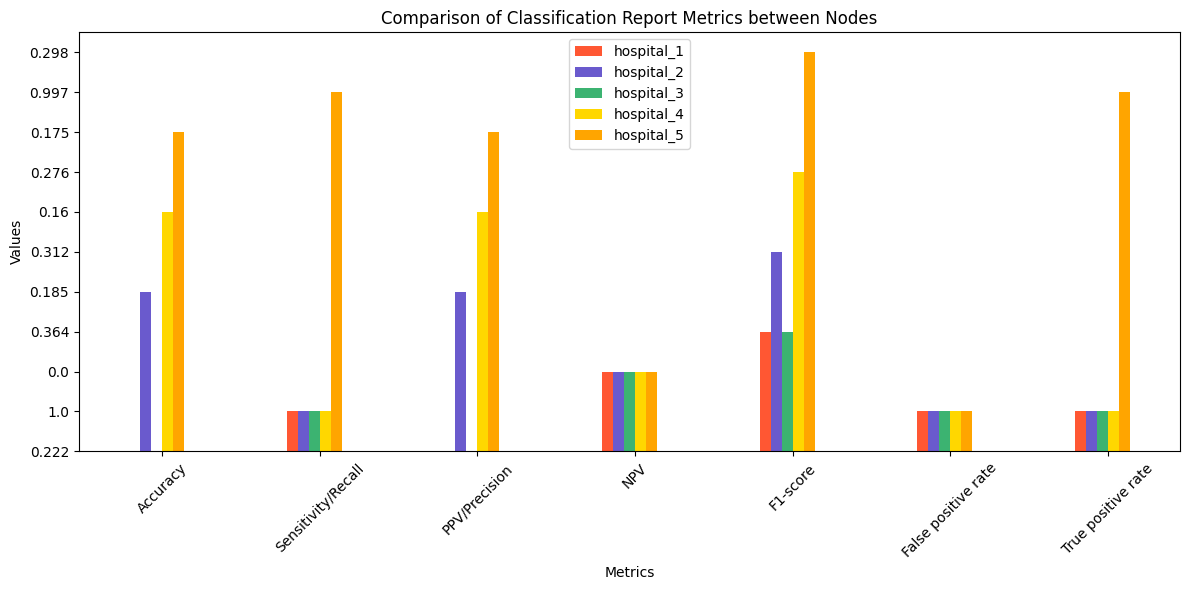

In [21]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")